In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load CSV
df = pd.read_csv("data/aptos2019/train.csv")
# df = pd.read_csv("data/diabetic_retinopathy/train.csv")

# Step 1: Split off test set (20%)
train_val_df, test_df = train_test_split(
    df, test_size=0.20, stratify=df["level"], random_state=42
)

# Step 2: Split train_val into train (70%) and val (10%)
# Since test is 20%, we need 10% of total = 10 / 80 = 12.5% of train_val for val
train_df, val_df = train_test_split(
    train_val_df, test_size=0.125, stratify=train_val_df["level"], random_state=42
)


# Confirm distribution
print("Train:", train_df["level"].value_counts(normalize=True))
print("Val:", val_df["level"].value_counts(normalize=True))
print("Test:", test_df["level"].value_counts(normalize=True))


Train: level
0    0.492974
2    0.272834
1    0.101093
4    0.080406
3    0.052693
Name: proportion, dtype: float64
Val: level
0    0.493188
2    0.272480
1    0.100817
4    0.081744
3    0.051771
Name: proportion, dtype: float64
Test: level
0    0.492497
2    0.272851
1    0.100955
4    0.080491
3    0.053206
Name: proportion, dtype: float64


In [86]:
import cv2
import numpy as np
from skimage.filters import frangi, hessian
from PIL import Image, ImageOps

def frangi_preprocessing(img, use_median_blur=False):
    # Convert PIL to numpy
    img = np.array(img)

    # Convert to Grayscale (for vessel enhancement)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Frangi or Hessian
    vessel_img = frangi(img)  # or hessian(clahe_img)
    vessel_img = (vessel_img * 255).astype('uint8')

    if use_median_blur:
        vessel_img = cv2.medianBlur(vessel_img, 3)
    else:
        vessel_img = cv2.GaussianBlur(vessel_img, (3, 3), 1)

    # Merge vessel map as extra channel
    # vessel_img = np.expand_dims(vessel_img, axis=2)
    # vessel_img = np.concatenate((img, vessel_img), axis=2)

    # Convert back to PIL
    return Image.fromarray(vessel_img)


def hessian_preprocessing(img, use_median_blur=False):
    # Convert PIL to numpy
    img = np.array(img)

    # Extract Green Channel
    green = img[:, :, 1]  # 0=Red, 1=Green, 2=Blue

    # Frangi or Hessian Vessel Enhancement
    vessel_img = hessian(green)  # Apply Hessian on green channel
    vessel_img = (vessel_img * 255).astype('uint8')

    # Optional Blur (Gaussian or Median)
    if use_median_blur:
        vessel_img = cv2.medianBlur(vessel_img, 3)
    else:
        vessel_img = cv2.GaussianBlur(vessel_img, (3, 3), 1)

    # Convert back to PIL
    return Image.fromarray(vessel_img)



In [87]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


class DiabeticRetinopathyDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None, preprocess=None):
        self.data = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform
        self.preprocess = preprocess

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_id = self.data.iloc[idx]['image']
        label = self.data.iloc[idx]['level']
        img_path = os.path.join(self.image_dir, img_id + '.png')
        
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)

        return image, label
    
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

val_test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

# train_dataset = DiabeticRetinopathyDataset(train_df, 'data/aptos2019/train_images', transform=train_transforms)
# val_dataset = DiabeticRetinopathyDataset(val_df, 'data/aptos2019/train_images', transform=val_test_transforms)
# test_dataset = DiabeticRetinopathyDataset(test_df, 'data/aptos2019/train_images', transform=val_test_transforms)

train_dataset = DiabeticRetinopathyDataset(train_df, 'data/aptos2019/train_images', transform=train_transforms, preprocess=hessian_preprocessing)
val_dataset = DiabeticRetinopathyDataset(val_df, 'data/aptos2019/train_images', transform=val_test_transforms, preprocess=hessian_preprocessing)
test_dataset = DiabeticRetinopathyDataset(test_df, 'data/aptos2019/train_images', transform=val_test_transforms, preprocess=hessian_preprocessing)

# train_dataset = DiabeticRetinopathyDataset(train_df, 'data/aptos2019/train_images', transform=train_transforms, preprocess=frangi_preprocessing)
# val_dataset = DiabeticRetinopathyDataset(val_df, 'data/aptos2019/train_images', transform=val_test_transforms, preprocess=frangi_preprocessing)
# test_dataset = DiabeticRetinopathyDataset(test_df, 'data/aptos2019/train_images', transform=val_test_transforms, preprocess=frangi_preprocessing)

# train_dataset = DiabeticRetinopathyDataset(train_df, 'data/diabetic_retinopathy/train', transform=train_transforms)
# val_dataset = DiabeticRetinopathyDataset(val_df, 'data/diabetic_retinopathy/train', transform=val_test_transforms)
# test_dataset = DiabeticRetinopathyDataset(test_df, 'data/diabetic_retinopathy/train', transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)




In [88]:
import torch
import torch.nn as nn
from torchvision import models
from transformers import SwinForImageClassification

# Load pretrained DenseNet-121
densenet = models.densenet121(pretrained=True)

# Remove the classifier head
densenet_backbone = densenet.features

# Load pretrained Swin Transformer
swin_model = SwinForImageClassification.from_pretrained("microsoft/swin-tiny-patch4-window7-224")

# Modify the input layer to accept DenseNet-121 features
swin_model.classifier = nn.Linear(in_features=1024, out_features=5)  # Assuming 5 DR severity levels



c:\Users\rylee\anaconda3\envs\dr\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rylee\anaconda3\envs\dr\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [89]:
class HybridModel(nn.Module):
    def __init__(self, densenet_backbone, swin_model):
        super(HybridModel, self).__init__()
        self.densenet = densenet_backbone
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # Pooling to match Swin input shape
        self.swin = swin_model

    def forward(self, x):
        x = self.densenet(x)  # Extract features using DenseNet-121
        x = self.pool(x).flatten(1)  # Pool and flatten for Swin Transformer
        x = self.swin.classifier(x)  # Final classification
        return x

# Initialize the hybrid model
model = HybridModel(densenet_backbone, swin_model)


In [90]:
from sklearn.metrics import precision_score, recall_score, f1_score
import torch.nn as nn
import matplotlib.pyplot as plt

@torch.no_grad()
def evaluate(model, dataloader):
    # Define device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Define loss function (same as in your training loop)
    criterion = nn.CrossEntropyLoss()

    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    all_preds = []
    all_labels = []

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    avg_loss = running_loss / len(dataloader)

    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    return accuracy, avg_loss, precision, recall, f1


In [91]:
import torch
from torch import nn, optim
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 15

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 30)

    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')

    acc, loss, precision, recall, f1 = evaluate(model, val_loader)

    print(f'Val Accuracy: {acc:.4f}')
    print(f'Val Loss: {loss:.4f}')
    print(f'Val Precision: {precision:.4f}')
    print(f'Val Recall: {recall:.4f}')
    print(f'Val F1 Score: {f1:.4f}')
    # Validation

torch.save(model.state_dict(), 'models/hessian_model_2.pth')



Epoch 1/15
------------------------------


  0%|          | 0/81 [00:00<?, ?it/s]

 21%|██        | 17/81 [01:38<06:01,  5.65s/it]

In [18]:
model.load_state_dict(torch.load('models/plain_model.pth'))
model.eval()

acc, loss, precision, recall, f1 = evaluate(model, val_loader)

print(f'Test Accuracy: {acc:.4f}')
print(f'Test Loss: {loss:.4f}')
print(f'Test  Precision: {precision:.4f}')
print(f'Test  Recall: {recall:.4f}')
print(f'Test  F1 Score: {f1:.4f}')

Test Accuracy: 0.8174
Test Loss: 0.6020
Test  Precision: 0.8308
Test  Recall: 0.8174
Test  F1 Score: 0.8223


In [44]:
model.load_state_dict(torch.load('models/frangi_model_2.pth'))
model.eval()

acc, loss, precision, recall, f1 = evaluate(model, val_loader)

print(f'Test Accuracy: {acc:.4f}')
print(f'Test Loss: {loss:.4f}')
print(f'Test  Precision: {precision:.4f}')
print(f'Test  Recall: {recall:.4f}')
print(f'Test  F1 Score: {f1:.4f}')

Test Accuracy: 0.8420
Test Loss: 0.7397
Test  Precision: 0.8358
Test  Recall: 0.8420
Test  F1 Score: 0.8316


In [36]:
model.load_state_dict(torch.load('models/frangi_median_model.pth'))
model.eval()

acc, loss, precision, recall, f1 = evaluate(model, val_loader)

print(f'Test Accuracy: {acc:.4f}')
print(f'Test Loss: {loss:.4f}')
print(f'Test  Precision: {precision:.4f}')
print(f'Test  Recall: {recall:.4f}')
print(f'Test  F1 Score: {f1:.4f}')

Test Accuracy: 0.7984
Test Loss: 0.5055
Test  Precision: 0.8264
Test  Recall: 0.7984
Test  F1 Score: 0.8019


In [52]:
model.load_state_dict(torch.load('models/hessian_model_2.pth'))
model.eval()

acc, loss, precision, recall, f1 = evaluate(model, val_loader)

print(f'Test Accuracy: {acc:.4f}')
print(f'Test Loss: {loss:.4f}')
print(f'Test  Precision: {precision:.4f}')
print(f'Test  Recall: {recall:.4f}')
print(f'Test  F1 Score: {f1:.4f}')


Test Accuracy: 0.8256
Test Loss: 0.5136
Test  Precision: 0.8423
Test  Recall: 0.8256
Test  F1 Score: 0.8274


In [80]:
model.load_state_dict(torch.load('models/hessian_model_2.pth'))
model.eval()

acc, loss, precision, recall, f1 = evaluate(model, val_loader)

print(f'Test Accuracy: {acc:.4f}')
print(f'Test Loss: {loss:.4f}')
print(f'Test  Precision: {precision:.4f}')
print(f'Test  Recall: {recall:.4f}')
print(f'Test  F1 Score: {f1:.4f}')

Test Accuracy: 0.7793
Test Loss: 0.5847
Test  Precision: 0.8253
Test  Recall: 0.7793
Test  F1 Score: 0.7886


In [83]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

def visualize_gradcam(model, dataset, indexes):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.eval()
    cam = GradCAM(model, target_layers=[model.densenet[-1]])

    plt.figure(figsize=(15, 5))

    for i in indexes:
        image, label = dataset[i]
        image = image.unsqueeze(0).to(device)  # Add batch dim
        output = model(image)
        _, pred = torch.max(output, 1)

        grayscale_cam = cam(input_tensor=image)[0]

        rgb_img = image.squeeze().permute(1, 2, 0).cpu().numpy()
        rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

        cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        plt.figure(figsize=(8, 8))
        plt.imshow(cam_image)
        plt.title(f"True: {label} | Pred: {pred.item()}")
        plt.axis('off')
    plt.show()


<Figure size 1500x500 with 0 Axes>

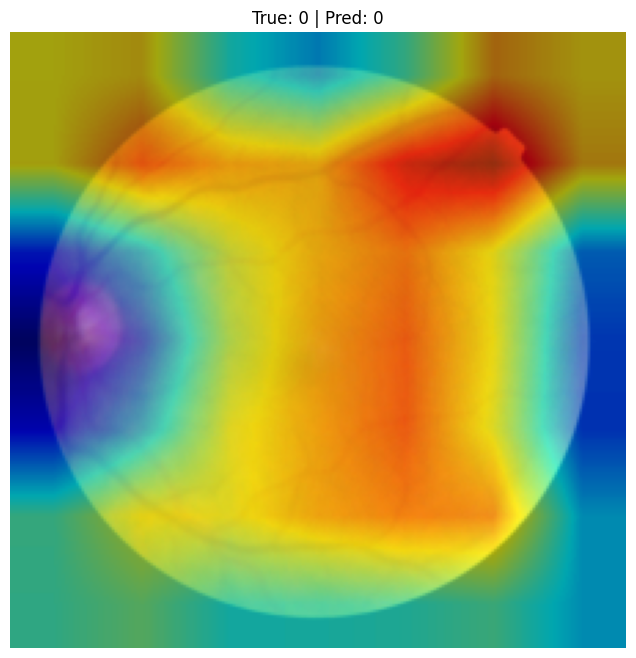

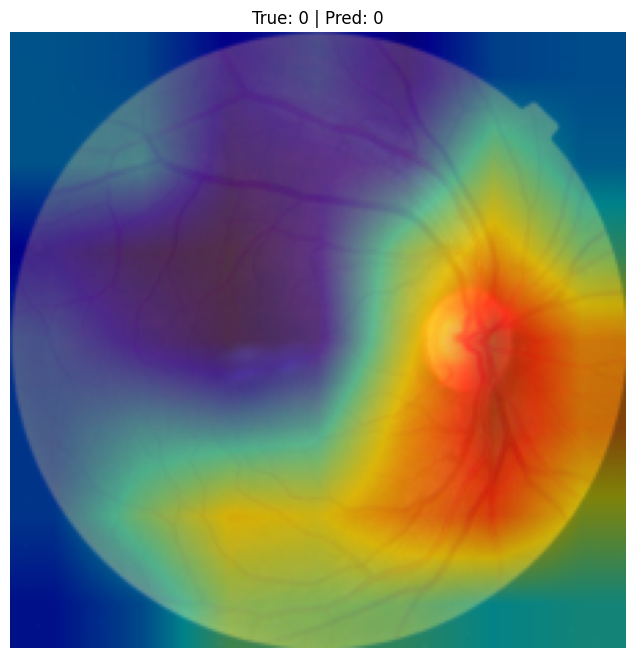

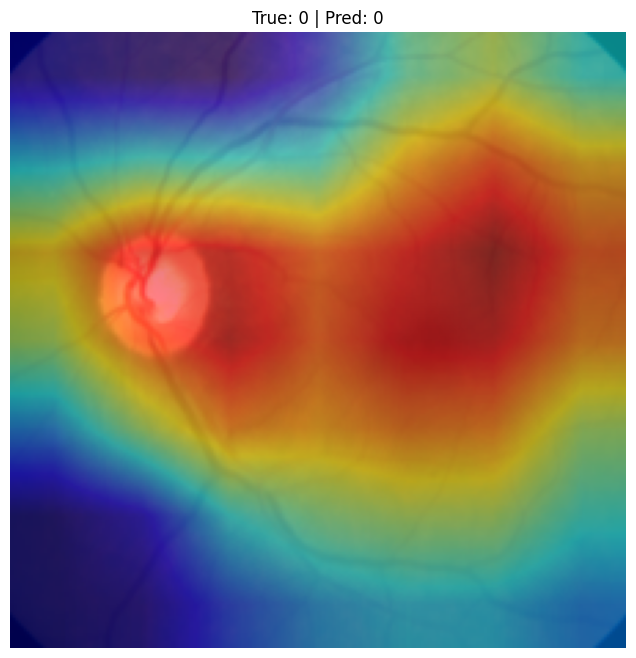

In [85]:
visualize_gradcam(model, test_dataset, [3, 4, 5])

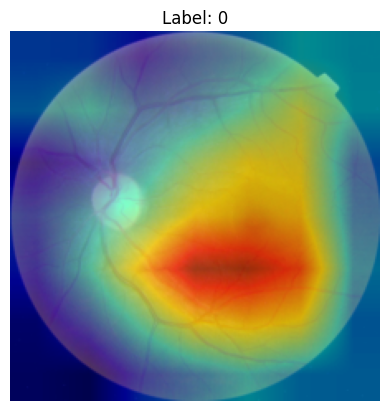

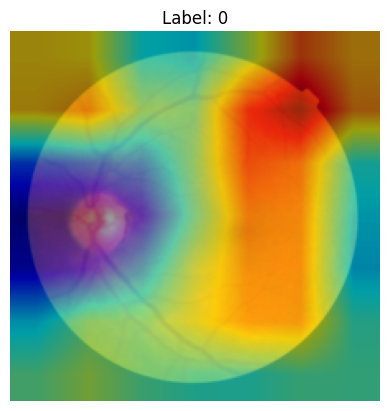

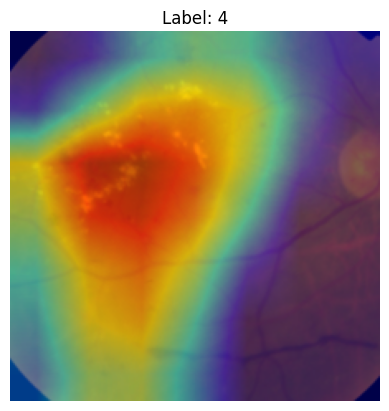

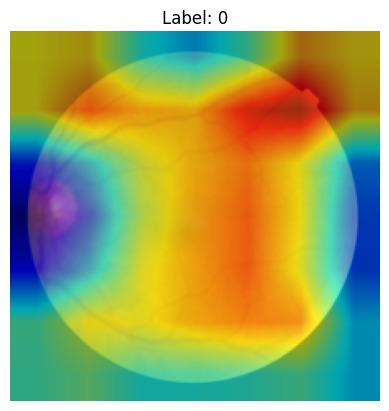

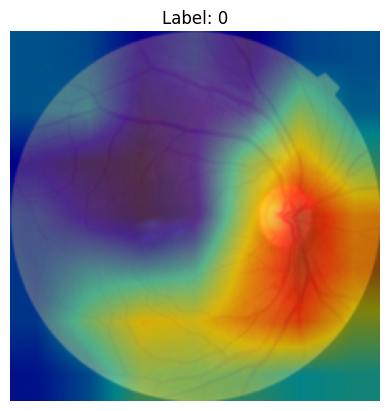

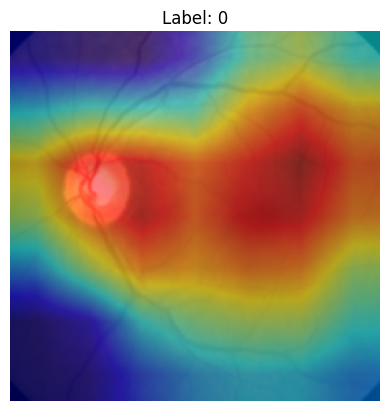

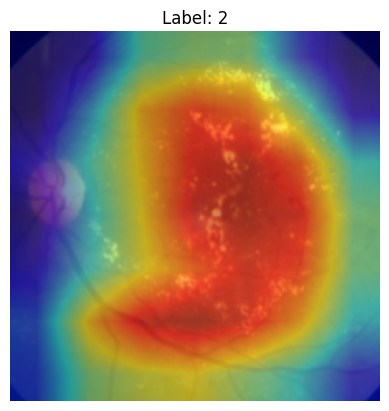

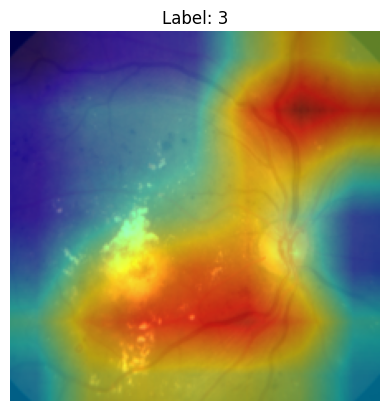

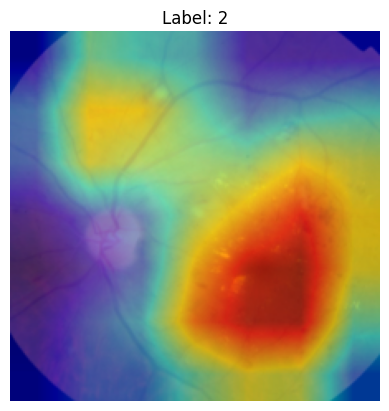

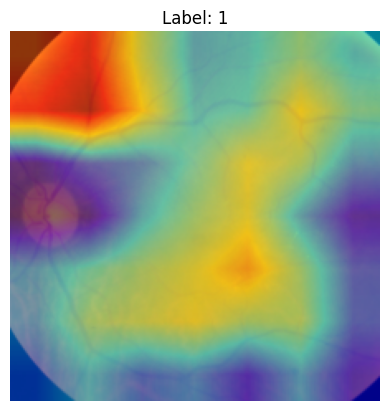

In [69]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import torch
import numpy as np
import matplotlib.pyplot as plt

# Pick target layer (last conv layer of DenseNet121 backbone)
target_layer = model.densenet[-1]   # update to your architecture

# Create GradCAM object
cam = GradCAM(model=model, target_layers=[target_layer])

# Loop through the first 10 images from the test dataset
for i in range(10):
    # Get image and label from the test dataset
    input_tensor, label = test_dataset[i]
    input_tensor = input_tensor.unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Generate CAM for the current image
    grayscale_cam = cam(input_tensor=input_tensor)[0]

    # Convert the image tensor to numpy array and normalize
    rgb_img = input_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

    # Apply GradCAM to the image
    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # Visualize the image with the GradCAM overlay and label
    plt.imshow(cam_image)
    plt.title(f"Label: {label.item()}")  # Show label as the title
    plt.axis('off')  # Turn off axes
    plt.show()


In [22]:
print(model.densenet) 


Sequential(
  (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (denseblock1): _DenseBlock(
    (denselayer1): _DenseLayer(
      (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (denselayer2): _DenseLayer(
      (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv1): Conv2d(96, 128, ke